# Backdoor Unlearning

## Outline

1. Experimental setup (generating configs)
2. Clean model training
3. Poisoned model training
4. First-order unlearning
5. Second-order unlearning
6. Visualizing results


## Experimental Setup

- All configurations to test are defined in the `[train|poison|unlearn].json` files (see below).
- If parameters are passed as list, all their combinations are tested in a grid-search manner.
- Only a single combination is provided for this demo. The original combinations are in `Applications/Poisoning/configs`
- The function generates directories and configuration files for each combination. They are later used by an evaluation script to run the experiment. This allows for parallelization and distributed execution.

In [1]:
import sys
sys.path.append('../')


In [2]:
# only if you are using CUDA devices
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"


In [3]:
from conf import BASE_DIR
from Applications.Poisoning.gen_configs import main as gen_configs

model_folder = BASE_DIR/'models'/'poisoning'
train_conf = BASE_DIR/'Applications'/'Poisoning'/'configs'/'demo'/'train.json'
poison_conf = BASE_DIR/'Applications'/'Poisoning'/'configs'/'demo'/'poison.json'
unlearn_conf = BASE_DIR/'Applications'/'Poisoning'/'configs'/'demo'/'unlearn.json'

gen_configs(model_folder, train_conf, poison_conf, unlearn_conf)

## Clean Model Training

- Train a clean model for reference.

In [6]:
from Applications.Poisoning.train import main as train

# train one clean and one poisoned model
train(model_folder=model_folder/'clean', modelname='ResNet50')

2024-06-20 11:48:57.868846: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/team1337/.local/easybuild_new/software/OpenMPI/4.0.5-GCC-10.2.0/lib:/home/team1337/.local/easybuild_new/software/PMIx/3.1.5-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/libfabric/1.11.0-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/UCX/1.9.0-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/libevent/2.1.12-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/hwloc/2.2.0-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/libpciaccess/0.16-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/libxml2/2.9.10-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/XZ/5.2.5-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/numactl/2.0.1

Epoch 1/100
782/782 [==============================] - 180s 219ms/step - loss: 2.1824 - accuracy: 0.1959 - val_loss: 3.2772 - val_accuracy: 0.2076
Epoch 2/100
782/782 [==============================] - 170s 218ms/step - loss: 1.9632 - accuracy: 0.2295 - val_loss: 2.1815 - val_accuracy: 0.2468
Epoch 3/100
782/782 [==============================] - 171s 218ms/step - loss: 1.6456 - accuracy: 0.3707 - val_loss: 1.6204 - val_accuracy: 0.3804
Epoch 4/100
782/782 [==============================] - 172s 220ms/step - loss: 1.4737 - accuracy: 0.4627 - val_loss: 1.4857 - val_accuracy: 0.4750
Epoch 5/100
782/782 [==============================] - 171s 219ms/step - loss: 1.3300 - accuracy: 0.5362 - val_loss: 2.7664 - val_accuracy: 0.3292
Epoch 6/100
782/782 [==============================] - 172s 220ms/step - loss: 1.2106 - accuracy: 0.5908 - val_loss: 1.3756 - val_accuracy: 0.5468
Epoch 7/100
782/782 [==============================] - 171s 218ms/step - loss: 1.1328 - accuracy: 0.6235 - val_loss: 1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



782/782 [==============================] - 168s 215ms/step - loss: 0.1149 - accuracy: 0.9713 - val_loss: 1.5601 - val_accuracy: 0.7618
Epoch 41/100
782/782 [==============================] - 168s 214ms/step - loss: 0.1143 - accuracy: 0.9716 - val_loss: 1.4500 - val_accuracy: 0.7822
Epoch 42/100
782/782 [==============================] - 169s 216ms/step - loss: 0.1071 - accuracy: 0.9736 - val_loss: 1.4811 - val_accuracy: 0.7820
Epoch 43/100
782/782 [==============================] - 167s 213ms/step - loss: 0.1085 - accuracy: 0.9738 - val_loss: 1.4636 - val_accuracy: 0.7628
Epoch 44/100
782/782 [==============================] - 168s 215ms/step - loss: 0.1016 - accuracy: 0.9761 - val_loss: 1.9699 - val_accuracy: 0.7520
Epoch 45/100
782/782 [==============================] - 169s 216ms/step - loss: 0.0966 - accuracy: 0.9770 - val_loss: 1.6039 - val_accuracy: 0.7738
Epoch 46/100
782/782 [==============================] - 171s 219ms/step - loss: 0.0920 - accuracy: 0.9779 - val_loss: 1.6634 

## Train Poisoned Model

- Select one of the generated configurations and train a poisoned model.
- The poisoning uses an `injector` object which can be persisted for reproducibility. It will inject the backdoors/label noise into the same samples according to a seed. In our experiments, we worked with label noise poisoning.

In [5]:
from Applications.Poisoning.poison.poison_models import train_poisoned
from Applications.Poisoning.configs.demo.config import Config

poisoned_folder = model_folder/'budget-10000'/'seed-42'
poison_kwargs = Config.from_json(poisoned_folder/'poison_config.json')
train_kwargs = Config.from_json(poisoned_folder/'train_config.json')

In [4]:

train_poisoned(model_folder=poisoned_folder, poison_kwargs=poison_kwargs, modelname='ResNet50', dataset="cifar10", train_kwargs=train_kwargs)

2024-06-20 17:21:35.930162: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/team1337/.local/easybuild_new/software/OpenMPI/4.0.5-GCC-10.2.0/lib:/home/team1337/.local/easybuild_new/software/PMIx/3.1.5-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/libfabric/1.11.0-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/UCX/1.9.0-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/libevent/2.1.12-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/hwloc/2.2.0-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/libpciaccess/0.16-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/libxml2/2.9.10-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/XZ/5.2.5-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/numactl/2.0.1

Epoch 1/100
782/782 [==============================] - 179s 217ms/step - loss: 2.3983 - accuracy: 0.1266 - val_loss: 2.2161 - val_accuracy: 0.1246
Epoch 2/100
782/782 [==============================] - 171s 218ms/step - loss: 2.2655 - accuracy: 0.1235 - val_loss: 65.4163 - val_accuracy: 0.1038
Epoch 3/100
782/782 [==============================] - 172s 220ms/step - loss: 1.9371 - accuracy: 0.2034 - val_loss: 3.2529 - val_accuracy: 0.2416
Epoch 4/100
782/782 [==============================] - 171s 218ms/step - loss: 1.8058 - accuracy: 0.2782 - val_loss: 2.0110 - val_accuracy: 0.2870
Epoch 5/100
782/782 [==============================] - 171s 219ms/step - loss: 1.7019 - accuracy: 0.3350 - val_loss: 2.4973 - val_accuracy: 0.2568
Epoch 6/100
782/782 [==============================] - 171s 218ms/step - loss: 1.6339 - accuracy: 0.3708 - val_loss: 2.5122 - val_accuracy: 0.3256
Epoch 7/100
782/782 [==============================] - 172s 220ms/step - loss: 1.5545 - accuracy: 0.4086 - val_loss: 

In [6]:
#poisoned_weights = poisoned_folder/'best_model.hdf5'
poisoned_weights = poisoned_folder/'ResNet50_cifar10poisoned_model.hdf5'# model that has been trained on poisoned data
fo_repaired_weights = poisoned_folder/'fo_repaired.hdf5'   # model weights after unlearning (first-order)
so_repaired_weights = poisoned_folder/'so_repaired.hdf5'   # model weights after unlearning (second-order)
injector_path = poisoned_folder/'injector.pkl'             # cached injector for reproducibility
clean_results = model_folder/'clean'/'train_results.json'  # path to reference results on clean dataset


## Unlearning

- Perform the first-order and second-order unlearning. The unlearning is wrapped in a function that
    - loads the clean data, saves the original labels
    - injects the poison (label noise)
    - creates difference set Z using `injector.injected_idx`
    - main unlearning happens in `Applications.Poisoning.unlearn.common.py:unlearn_update` and the thereby called `iter_approx_retraining` method
- The variable naming follows the following ideas:
    - `z_x`, `z_y`: features (x) and labels (y) in set `Z`
    - `z_x_delta`, `z_y_delta`: changed features and labels (`z_x == z_x_delta` here and `z_y_delta` contains the original (fixed) labels)
- A word about why iterative:
    - The approximate retraining is configured to unlearn the desired changes in one step.
    - To avoid putting a lot of redundant erroneous samples in the changing set `Z`, the iterative version
        - takes a sub-sample (`prio_idx`) of `hvp_batch_size` in the delta set `Z`
        - makes one unlearning step
        - recalculates the delta set and focuses only on remaining errors
    - The idea here is that similar to learning, it is better to work iteratively in batches since the approximation quality of the inverse hessian matrix decreases with the number of samples included (and the step size)

/home/ameck.dosseh/conite/MU_ENV/lib/python3.7/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

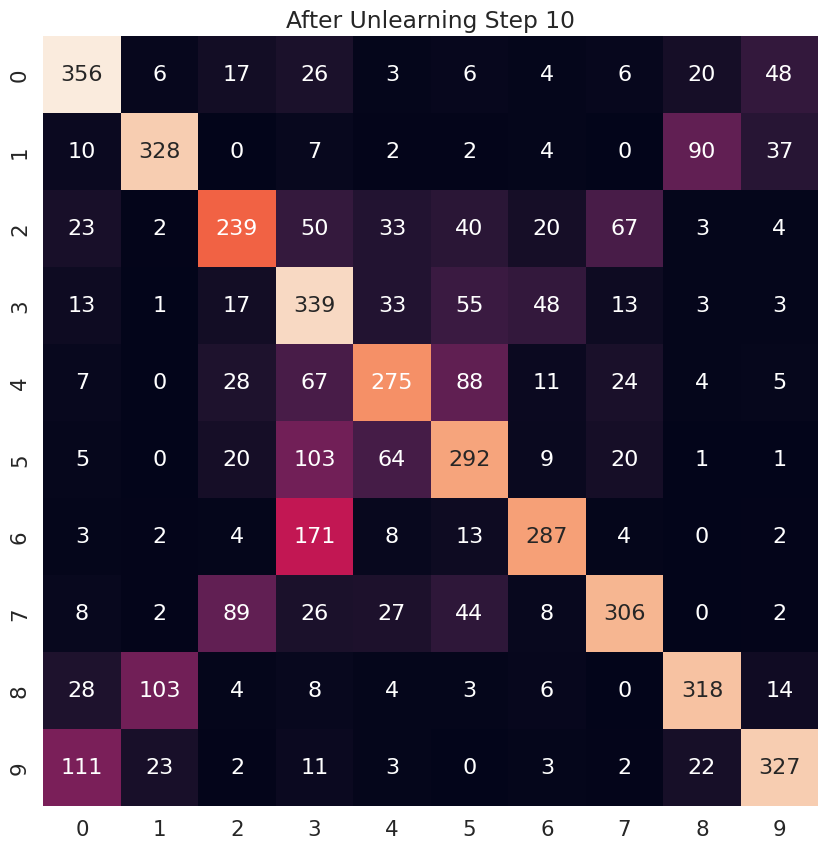

In [10]:
from Applications.Poisoning.unlearn.first_order import run_experiment as fo_experiment
from Applications.Poisoning.unlearn.second_order import run_experiment as so_experiment

fo_unlearn_kwargs = Config.from_json(poisoned_folder/'first-order'/'unlearn_config.json')
so_unlearn_kwargs = Config.from_json(poisoned_folder/'second-order'/'unlearn_config.json')

#fo_experiment(poisoned_folder/'first-order', train_kwargs, poison_kwargs, fo_unlearn_kwargs)
#so_experiment(poisoned_folder/'second-order', train_kwargs, poison_kwargs, so_unlearn_kwargs)


fo_experiment(poisoned_folder/'first-order', train_kwargs, poison_kwargs, fo_unlearn_kwargs, modelname="ResNet50", dataset="cifar10")


Early stopping at iteration 219. Update norm 55234.475892663 > [55097.169111549854, 20]
Early stopping at iteration 135. Update norm 108813.2051744461 > [107977.16432332993, 20]
Early stopping at iteration 59. Update norm 106814.70861339569 > [106493.5097913742, 20]
Early stopping at iteration 139. Update norm 44939.84778380394 > [43881.0059376955, 20]
Early stopping at iteration 69. Update norm 101168.85951220989 > [98623.93386626244, 20]
Early stopping at iteration 103. Update norm 66724.59530830383 > [62948.68083834648, 20]
Early stopping at iteration 78. Update norm 101777.85922884941 > [89547.97910189629, 20]
Early stopping at iteration 72. Update norm 53593.190408587456 > [53499.74383878708, 20]
Early stopping at iteration 94. Update norm 55952.550924897194 > [50845.067685484886, 20]
Early stopping at iteration 91. Update norm 79645.22880840302 > [76401.34603273869, 20]


/home/ameck.dosseh/conite/MU_ENV/lib/python3.7/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

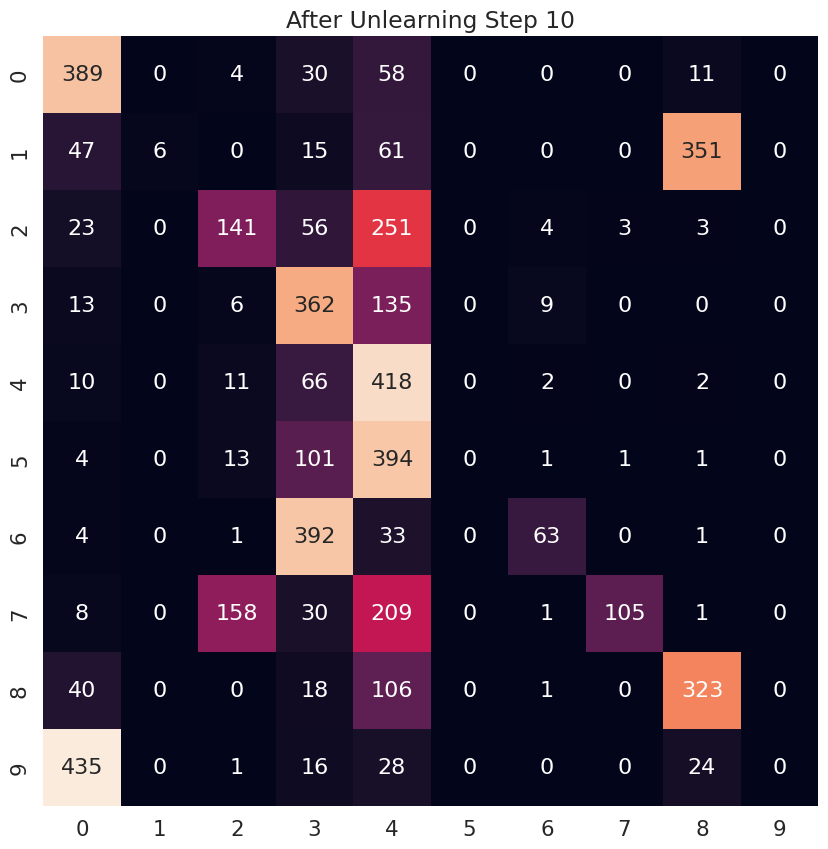

In [11]:
so_experiment(poisoned_folder/'second-order', train_kwargs, poison_kwargs, so_unlearn_kwargs, modelname="ResNet50", dataset="cifar10")

## Visualizing the Results

- To give some notion of how well the unlearning worked, we plot confusion matrices before and after unlearning.
- This is just an example and not required for unlearning.

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8

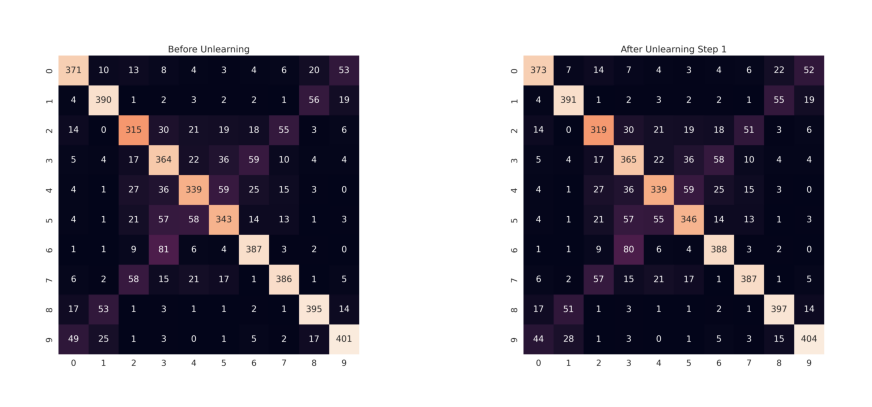

In [15]:
cm_before = mpimg.imread(poisoned_folder/'first-order'/'cm'/'cm_unlearning_00.png')
cm_after = mpimg.imread(poisoned_folder/'first-order'/'cm'/'cm_unlearning_01.png')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(cm_before)
ax[1].imshow(cm_after)
ax[0].grid(False)
ax[1].grid(False)
ax[0].tick_params(left=False, right=False , labelleft=False, labelbottom=False, bottom=False)
ax[1].tick_params(left=False, right=False , labelleft=False, labelbottom=False, bottom=False)

plt.show()

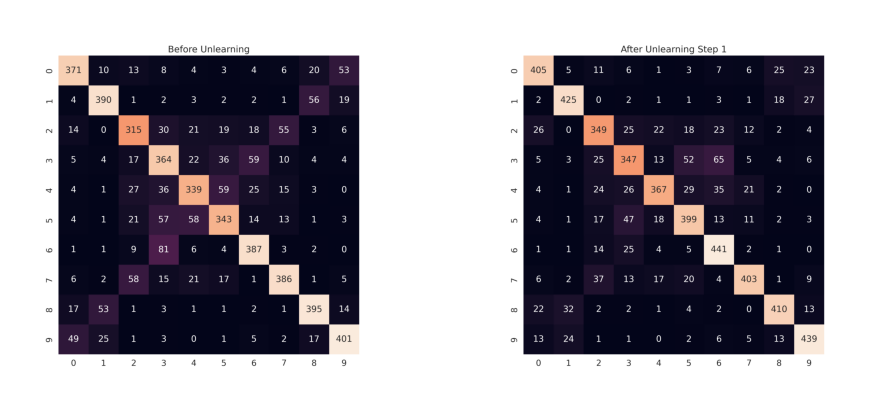

In [16]:
cm_before = mpimg.imread(poisoned_folder/'second-order'/'cm'/'cm_unlearning_00.png')
cm_after = mpimg.imread(poisoned_folder/'second-order'/'cm'/'cm_unlearning_01.png')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(cm_before)
ax[1].imshow(cm_after)
ax[0].grid(False)
ax[1].grid(False)
ax[0].tick_params(left=False, right=False , labelleft=False, labelbottom=False, bottom=False)
ax[1].tick_params(left=False, right=False , labelleft=False, labelbottom=False, bottom=False)

plt.show()

As you can see, the second-order unlearning is able to fix some of the missing accuracy. However, it can also be observed that the unlearning is not exact in the non-convex setting.